In [31]:
import numpy
import time
import matplotlib.pyplot as plt
import ipyparallel as ipp
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.chemistry import FermionicOperator
from qiskit.providers.aer import AerSimulator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from joblib import Parallel, delayed
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD

In [32]:
%run Utils.ipynb

In [33]:
import warnings
warnings. filterwarnings('ignore')

In [34]:
c = ipp.Client()
num_qubits=8

In [35]:
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [48]:
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    state_g=v[:,0]
    return qubitH,Hmat,Eg,state_g

In [49]:
U=7#3
Eg=-19.18498504086919#-8.321801091622758

In [50]:
#One particle density matrix-statevector
def one_RDM(data):
    import numpy
    from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
    from qiskit_nature.mappers.second_quantization import JordanWignerMapper
    state,num_qubits,i,j=data
    mapper=JordanWignerMapper()
    h1=numpy.zeros((num_qubits,num_qubits))*1j
    h2=numpy.zeros((num_qubits,num_qubits))*1j
    h1[i,j]=h1[j,i]=0.5
    h2[i,j]=0.5*1j
    h2[j,i]=-0.5*1j
    h1=fermionic_op_builder.build_ferm_op_from_ints(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h2=fermionic_op_builder.build_ferm_op_from_ints(h2,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h1=mapper.map(h1)
    h2=mapper.map(h2)
    h1=h1.to_matrix(massive=True)
    h2=h2.to_matrix(massive=True)
    h=h1+1j*h2
    return state@h@state
def M(state):
    num_qubits=8
    arr=[(state,num_qubits,i,j) for i in range(num_qubits) for j in range(num_qubits) if i<=j]
    result = c[:].map_async(one_RDM, arr)
    M_arr=result.get()
    adapt_RDM=numpy.zeros((num_qubits,num_qubits))*1j
    ind=0
    for i in range(num_qubits):
        for j in range(i,num_qubits):
            adapt_RDM[i,j]=M_arr[ind]
            adapt_RDM[j,i]=numpy.conjugate(M_arr[ind])
            ind=ind+1
    return adapt_RDM
def dist(rho1,rho2):
    rho_diff=rho1-rho2
    entries=num_qubits*num_qubits
    d_12=numpy.sum(numpy.abs(rho_diff))/len(rho_diff[numpy.abs(rho_diff)>1e-5])#numpy.sqrt(numpy.sum(numpy.diag(numpy.dot(rho_diff,numpy.conjugate(rho_diff.T)))))
    return d_12
def error_one_body_DM(adapt_RDMs,exact_RDM,U,file_name):
    error_arr=[]
    qubit_inds=[]
    for j in range(num_qubits):
        for k in range(j,num_qubits):
            if(numpy.abs(exact_RDM[j,k])>1e-6):
                qubit_inds.append((j,k))
    for i in range(len(adapt_RDMs)):
        err_arr=[]
        for l in range(len(qubit_inds)):
            j,k=qubit_inds[l]
            err_arr.append(numpy.abs(adapt_RDMs[i][j,k]-exact_RDM[j,k]))
        error_arr.append(numpy.array(err_arr))            
    error_arr=numpy.array(error_arr)
    qubit_inds_str=' '.join(["("+str(qubit_inds[i][0])+" "+str(qubit_inds[i][1])+")" for i in range(len(qubit_inds))])
    f=open('../'+str(U)+'/'+file_name,'w')
    f.write(qubit_inds_str+'\n')
    f.close()
    for i in range(len(adapt_RDMs)):
        with open('../'+str(U)+'/'+file_name,'a') as f:
            err_str=" ".join([str(error_arr[i][j]) for j in range(len(qubit_inds))])
            print(err_str,file=f)
    return True

In [76]:
# #results from HVA statevector
U=7
EnergyArrHVAcomp=[]
paramsArr=[]
with open('../'+str(U)+'/FinalDataFiles/HVA-opt-SMO&AdaDelta/SMOforHVA.txt','r') as f:
    lines=f.readlines()
    data=lines[0].split('#')
    Len=len(eval(data[0]))
    points=[]
    EnergyArrHVAcomp.append(float(data[1]))
    paramsArr.append(eval(data[0]))
    for i in range(1,len(lines)):
        data=lines[i].split('#')
        paramsArr.append(eval(data[0]))
        EnergyArrHVAcomp.append(float(data[1]))
        if len(paramsArr[-1])>Len:
            Len=len(eval(data[0]))
            points.append(i-1)
        else:
            continue
    points.append(-1)            
EnergyArrHVA=numpy.array(EnergyArrHVAcomp)[numpy.array(points)]
numCXarrHVA=[(32+4)*2*2,(32+4)*2*3,(32+4)*2*4,(32+4)*2*5,(32+4)*2*6,(32+4)*2*7]


In [77]:
points

[155, 409, 2672, 4880, 4899, -1]

In [66]:
#results from Statevector with UCCSD pool
# #results from qasm
U=7
EnergyArrUCCSD=[]
paramsArr=[]
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-UCCSD-pool/SMOoptStepsWithSV.txt','r') as f:
    lines=f.readlines()
    data=lines[0].split('#')
    Len=len(eval(data[0]))
    points=[]
    EnergyArrUCCSD.append(float(data[1]))
    paramsArr.append(eval(data[0]))
    for i in range(1,len(lines)):
        data=lines[i].split('#')
        paramsArr.append(eval(data[0]))
        EnergyArrUCCSD.append(float(data[1]))
        if len(paramsArr[-1])>Len:
            Len=len(eval(data[0]))
            points.append(i-1)
        else:
            continue
    points.append(-1)            
EnergyArrAdaptUCCSD=numpy.array(EnergyArrUCCSD)[numpy.array(points)]
numCXarrUCCSD=[]
numCX=0
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-UCCSD-pool/labelsUCCSD.txt') as f:
    lines=f.readlines()
    for line in lines:
        numCX=numCX+countCXs(line[:-1])
        numCXarrUCCSD.append(numCX)    

In [67]:
# #results from qasm
U=7
EnergyArr=[]
paramsArr=[]
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-adaDelta/adaDeltaOptStepsWithQasm16384,16384,16384.txt','r') as f:
    lines=f.readlines()
    data=lines[0].split('#')
    Len=len(eval(data[0]))
    points=[]
    EnergyArr.append(float(data[1]))
    paramsArr.append(eval(data[0]))
    for i in range(1,len(lines)):
        data=lines[i].split('#')
        paramsArr.append(eval(data[0]))
        EnergyArr.append(float(data[1]))
        if len(paramsArr[-1])>Len:
            Len=len(eval(data[0]))
            points.append(i-1)
        else:
            continue
    points.append(-1)            
EnergyArrAdapt=numpy.array(EnergyArr)[numpy.array(points)]
numCXarr=[]
numCX=0
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-adaDelta/labels.txt') as f:
    lines=f.readlines()
    for line in lines:
        numCX=numCX+countCXs(line[:-1])
        numCXarr.append(numCX)
# Labels_qasm=[]
# with open('../'+str(U)+'/FinalDataFiles-commutator_pool/adaptVQE-opt-adaDelta/labels.txt','r') as f:
#     lines=f.readlines()
#     CXarr_qasm=[]
#     Labels_qasm=[]
#     numCX=0
#     for line in lines:
#         Labels_qasm.append(line[:-1])
#         numCX=numCX+countCXs(line[:-1])
#         CXarr_qasm.append(numCX)     
# qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
# exactRDM=M(state_g)
# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()
# adaptRDMs=[]
# distRDMs=[]
# for i in range(len(Labels_qasm)):
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels_qasm[i])]]))
#     circ=var_form_base.construct_circuit(paramsArr[points[i]])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1])
# error_one_body_DM(adaptRDMs,exactRDM,U,'qasm_adadelta_error_one_body_dm.txt')   
# U=7
# with open('../'+str(U)+'/qasm_adadelta_error_one_body_dm.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_qasm=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_qasm[ind][i]=float(elems[i])
#         ind=ind+1   

In [68]:
U=7
EnergyArr2=[]
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-var_reduction/results.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        elems=line.split(',')
        EnergyArr2.append(float(elems[2][:-2])) 
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-var_reduction/adaptRunDataQasm.txt','r') as f:
    lines=f.readlines()
    Len=len(eval(lines[0]))
    paramsArr=[]
    points=[]
    paramsArr.append(eval(lines[0]))
    for i in range(1,len(lines)):
        paramsArr.append(eval(lines[i]))
        if len(eval(lines[i]))>Len:
            Len=len(eval(lines[i]))
            points.append(i-1)    
    points.append(len(lines)-1)
EnergyArrAdapt2=numpy.array(EnergyArr2)[numpy.array(points)]    
numCXarr2=[]
numCX=0
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-var_reduction/labels.txt') as f:
    lines=f.readlines()
    for line in lines:
        numCX=numCX+countCXs(line[:-1])
        numCXarr2.append(numCX) 
# Labels_qasm=[]
# with open('../'+str(U)+'/FinalDataFiles-commutator_pool/adaptVQE-opt-SMO-var_reduction/labels.txt','r') as f:
#     lines=f.readlines()
#     CXarr_qasm2=[]
#     Labels_qasm=[]
#     numCX=0
#     for line in lines:
#         Labels_qasm.append(line[:-1])
#         numCX=numCX+countCXs(line[:-1])
#         CXarr_qasm2.append(numCX)          
# qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
# exactRDM=M(state_g)
# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()
# adaptRDMs=[]
# distRDMs=[]
# for i in range(len(Labels_qasm)):
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels_qasm[i])]]))
#     circ=var_form_base.construct_circuit(paramsArr[points[i]])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1])
# error_one_body_DM(adaptRDMs,exactRDM,U,'qasm_smo_variates_error_one_body_dm.txt')   
# U=7
# with open('../'+str(U)+'/qasm_smo_variates_error_one_body_dm.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_qasm2=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_qasm2[ind][i]=float(elems[i])
#         ind=ind+1         

In [69]:
#results from qasm
EnergyArr1=[]
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO/results.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        elems=eval(line)
        EnergyArr1.append(float(elems[2]))
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO/adaptRunDataQasm.txt','r') as f:
    lines=f.readlines()
    Len=len(eval(lines[0]))
    paramsArr=[]
    paramsArr.append(eval(lines[0]))
    points=[]
    for i in range(1,len(lines)):
        paramsArr.append(eval(lines[i]))
        if len(eval(lines[i]))>Len:
            Len=len(eval(lines[i]))
            points.append(i-1)    
    points.append(len(lines)-1)
EnergyArrAdapt1=numpy.array(EnergyArr1)[numpy.array(points)]    
numCXarr1=[]
numCX=0
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO/labels.txt') as f:
    lines=f.readlines()
    for line in lines:
        numCX=numCX+countCXs(line[:-1])
        numCXarr1.append(numCX)    
# EnergyArrAdapt1=numpy.array(EnergyArr1)[numpy.array(points)]    
# numCXarr1=[]
# numCX=0
# with open('../'+str(U)+'/FinalDataFiles-commutator_pool/adaptVQE-opt-SMO/labels.txt') as f:
#     lines=f.readlines()
#     for line in lines:
#         numCX=numCX+countCXs(line[:-1])
#         numCXarr1.append(numCX) 
# Labels_qasm=[]
# with open('../'+str(U)+'/FinalDataFiles-commutator_pool/adaptVQE-opt-SMO/labels.txt','r') as f:
#     lines=f.readlines()
#     CXarr_qasm1=[]
#     Labels_qasm=[]
#     numCX=0
#     for line in lines:
#         Labels_qasm.append(line[:-1])
#         numCX=numCX+countCXs(line[:-1])
#         CXarr_qasm1.append(numCX)          
# qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
# exactRDM=M(state_g)
# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()
# adaptRDMs=[]
# distRDMs=[]
# for i in range(len(Labels_qasm)):
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels_qasm[i])]]))
#     circ=var_form_base.construct_circuit(paramsArr[points[i]])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1])
# error_one_body_DM(adaptRDMs,exactRDM,U,'qasm_smo_error_one_body_dm.txt')   
# U=7
# with open('../'+str(U)+'/qasm_smo_error_one_body_dm.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_qasm1=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_qasm1[ind][i]=float(elems[i])
#         ind=ind+1                 
# with open('../'+str(U)+'/adaptRunDataQasm.txt','r') as f:
#     lines=f.readlines()
#     Len=len(eval(lines[0]))
#     params_arr=[]
#     points=[]
#     for i in range(1,len(lines)):
#         if len(eval(lines[i]))>Len:
#             Len=len(eval(lines[i]))
#             points.append(i-1)
#             params_arr.append(eval(lines[i-1]))
#         else:
#             continue
# points.append(len(lines)-2)
# params_arr.append(eval(lines[-2]))
# EnergyArrEstm2=numpy.array(EnergyArrEstm)
# EnergyArrEstm2=EnergyArrEstm2[numpy.array(points)]                
# with open('../'+str(U)+'/labelsQasm_HF_commutator_pool.txt','r') as f:
#     lines=f.readlines()
#     CXarr_qasm=[]
#     Labels_qasm=[]
#     numCX=0
#     for line in lines:
#         Labels_qasm.append(line)
#         numCX=numCX+countCXs(line)
#         CXarr_qasm.append(numCX)     
# Labels_qasm=[Labels_qasm[i][:-1] for i in range(len(Labels_qasm))]

# U=3
# qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
# exactRDM=M(state_g)
# Hmat2=op_converter.to_matrix_operator(qubitH.multiply(qubitH)).dense_matrix
# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()
# #building density matrix from qasm
# adaptRDMs=[]
# distRDMs=[]
# backend=Aer.get_backend('statevector_simulator')
# EnergyFluc_qasm=[]
# for i in range(len(Labels_qasm)):
#     print(Labels_qasm[i])
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(Labels_qasm[i])]]))
#     print(params_arr[i])
#     circ=var_form_base.construct_circuit(params_arr[i])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     EnergyFluc_qasm.append((state@Hmat2@numpy.conjugate(state)-(state@Hmat@numpy.conjugate(state))**2).real)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1])
# error_one_body_DM(adaptRDMs,exactRDM,U)   
# U=3
# with open('../'+str(U)+'/qasm_error_one_body_dm.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_qasm=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_qasm[ind][i]=float(elems[i])
#         ind=ind+1   

In [70]:
# #results from statevector
# EnergyArr=[]
# with open('../'+str(U)+'/resultSV_HF_c_pool.txt','r') as f:
#     lines=f.readlines()
#     for line in lines[1:]:
#         elems=eval(line)
#         EnergyArr.append(float(elems))
# with open('../'+str(U)+'/adaptRunDataSV_HF_c_pool.txt','r') as f:
#     lines=f.readlines()
#     Len=len(eval(lines[0]))
#     params_arr=[]
#     points=[]
#     for i in range(1,len(lines)):
#         if len(eval(lines[i]))>Len:
#             Len=len(eval(lines[i]))
#             points.append(i-1)
#             params_arr.append(eval(lines[i-1]))
#         else:
#             continue
# points.append(len(lines)-2)
# params_arr.append(eval(lines[-2]))
# EnergyArr=numpy.array(EnergyArr)
# EnergyArr=EnergyArr[numpy.array(points)]                
# with open('../'+str(U)+'/labelsSV_HF_c_pool.txt','r') as f:
#     lines=f.readlines()
#     CXarrSV=[]
#     LabelsSV=[]
#     numCX=0
#     for line in lines:
#         LabelsSV.append(line[:-1])
#         numCX=numCX+countCXs(line)
#         CXarrSV.append(numCX)     
# U=3
# qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)
# exactRDM=M(state_g)
# Hmat2=op_converter.to_matrix_operator(qubitH.multiply(qubitH)).dense_matrix
# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()
# #building density matrix from qasm
# adaptRDMs=[]
# distRDMs=[]
# backend=Aer.get_backend('statevector_simulator')
# EnergyFlucSV=[]
# for i in range(len(LabelsSV)):
#     print(LabelsSV[i])
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(LabelsSV[i])]]))
#     print(params_arr[i])
#     circ=var_form_base.construct_circuit(params_arr[i])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     EnergyFlucSV.append((state@Hmat2@numpy.conjugate(state)-(state@Hmat@numpy.conjugate(state))**2).real)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1])
# error_one_body_DM(adaptRDMs,exactRDM,U)
# U=3
# with open('../'+str(U)+'/sv_error_one_body_dm.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_sv=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_sv[ind][i]=float(elems[i])
#         ind=ind+1   

In [71]:
# #results from statevector
# with open('../7/QasmVsStatevector/HF_statevector_adapt_VQE.txt','r') as f:
#     lines=f.readlines()
#     labelsSV=[]
#     EnergyArrSV=[]
#     CXarrSV=[]
#     for line in lines[2:]:
#         elems=line.split()
#         labelsSV.append(elems[1])
#         EnergyArrSV.append(float(elems[2]))
#         CXarrSV.append(int(elems[-1]))
# with open('../7/QasmVsStatevector/adaptRunData.txt','r') as f:
#     lines=f.readlines()
#     sv_params_arr=[]
#     for i in range(len(lines)):      
#         sv_params_arr.append(eval(lines[i]))
# U=7

# backend=Aer.get_backend('statevector_simulator')
# HFcirc,HFstate=HF_init_state(U)
# var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
# var_form_base.manage_hopping_operators()        
# #building density matrix from qasm
# adaptRDMs=[]
# distRDMs=[]
# backend=Aer.get_backend('statevector_simulator')
# EnergyFlucSV=[]
# for i in range(len(labelsSV)):
#     var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(labelsSV[i])]]))
#     circ=var_form_base.construct_circuit(sv_params_arr[i])
#     state=execute(circ,backend,shots=1024).result().get_statevector()
#     global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#     state=state/numpy.sqrt(global_phase)
#     EnergyFlucSV.append((state@Hmat2@numpy.conjugate(state)-(state@Hmat@numpy.conjugate(state))**2).real)
#     adaptRDMs.append(M(state))
#     distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#     print("distance between RDMs",distRDMs[-1]) 
# error_one_body_DM(adaptRDMs,exactRDM,U)    
# with open('sv_error_one_body_dmU=7.txt','r') as f:
#     lines=f.readlines()
#     ind=0
#     dm_error_arr_sv=numpy.zeros((len(lines[1:]),12))
#     for line in lines[1:]:
#         elems=line.split()
#         for i in range(len(elems)):
#             dm_error_arr_sv[ind][i]=float(elems[i])
#         ind=ind+1       

In [72]:
with open('../7/FinalDataFiles/adaptVQE-opt-SMO-SV/sv_HF-state-AO-Givens-q-adapt-SMO-commutator-pool_new.txt') as f:
    lines=f.readlines()
    Earr=[]
    CXarr=[]
    for line in lines[2:]:
        elems=line.split()
        Earr.append(float(elems[2]))
        CXarr.append(int(elems[5]))

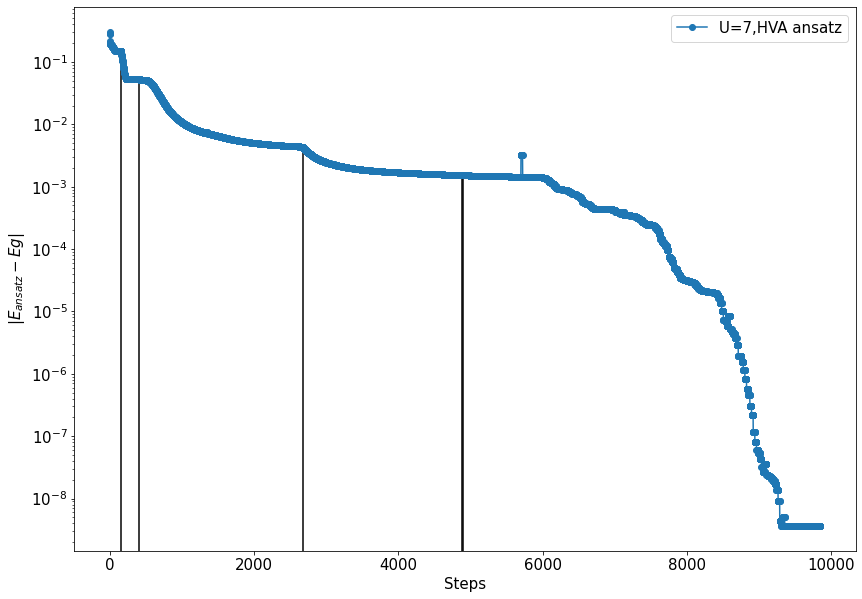

In [81]:
figure,ax=plt.subplots(1,figsize = (14,10))
#ax2 = figure.add_axes([0.17, 0.2, 0.2, 0.3])
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,0))
# ax2.plot(
# MSE_arr,
#     ls="solid",
#     color="k",
#     linewidth=0.5,
#     label="MSE",
# )
#ax2.set_xlabel('Steps',fontsize=12)
#ax2.legend(fontsize=15)
ax.set_xlabel("Steps",fontsize=15)
ax.set_ylabel(r'$|E_{ansatz}-Eg|$',fontsize=15)
#ax.plot(numpy.abs(numpy.array(EnergyArr)-Eg),marker='o',linestyle='-',label='U='+str(U)+r',AdaDeltawithQASM,$2^{14}\times 3$')
#ax.plot(numpy.abs(numpy.array(EnergyArr1)-Eg),marker='o',linestyle='-',label='U='+str(U)+r',SMOwithQASM,$2^{18},2^{21},2^{20}$')
#ax.plot(numpy.abs(numpy.array(EnergyArr2)-Eg),marker='o',linestyle='-',label='U='+str(U)+r',ControlVariate,$(2^{14}\times 20+2^{12})\times 3$')
ax.plot(numpy.abs(numpy.array(EnergyArrHVAcomp)-Eg),marker='o',linestyle='-',label='U='+str(U)+r',HVA ansatz')
# multiple lines with varying ymin and ymax 
plt.vlines(x = points[:-1], ymin = [0]*len(points), ymax=numpy.abs(numpy.array(EnergyArrHVA[:-1])-Eg)) 
ax.set_yscale('log')
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
    #ax[1].set_yscale('log')
    #ax[1].tick_params(labelsize=15)
    #ax[1].legend(fontsize=15)
plt.savefig("../"+str(U)+"/HVA-U-%s.png"%str(U)) 

In [60]:
# figure,ax=plt.subplots(1,figsize = (12,7))
# ax.set_xlabel("optimization steps",fontsize=15)
# ax.set_ylabel(r'$|E_{ansatz}-Eg|$',fontsize=15)
# ax.plot(numpy.abs(numpy.array(EnergyArrEstm)-Eg),marker='o',linestyle='-',label='U='+str(U)+r', $E_{estm}$ from SMO & QASM')
# ax.plot(numpy.abs(numpy.array(EnergyArrExact)-Eg),marker='o',markersize=2,linestyle='-',label='U='+str(U)+r', $E_{exact}$ with params from qasm')    
# ax.set_yscale('log')
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)
#     #ax[1].set_yscale('log')
#     #ax[1].tick_params(labelsize=15)
#     #ax[1].legend(fontsize=15)
# for i in range(len(points)):
#     ax.vlines(points[i],numpy.array(EnergyArrExact[points[i]]-Eg),10**-6,colors="grey",linewidth=0.5,linestyle='--')
# plt.savefig("../"+str(U)+"/qasmASMO_marks-U-%s.png"%str(U))     

In [61]:
len(numCXarrHVA), len(EnergyArrHVA)

(6, 6)

In [62]:
numpy.array(EnergyArrHVA)-Eg

array([1.49679783e-01, 5.24333529e-02, 4.37743830e-03, 1.52532001e-03,
       1.52223283e-03, 3.61759334e-09])

In [63]:
len(EnergyArrAdaptUCCSD),len(numCXarrUCCSD)

(33, 35)

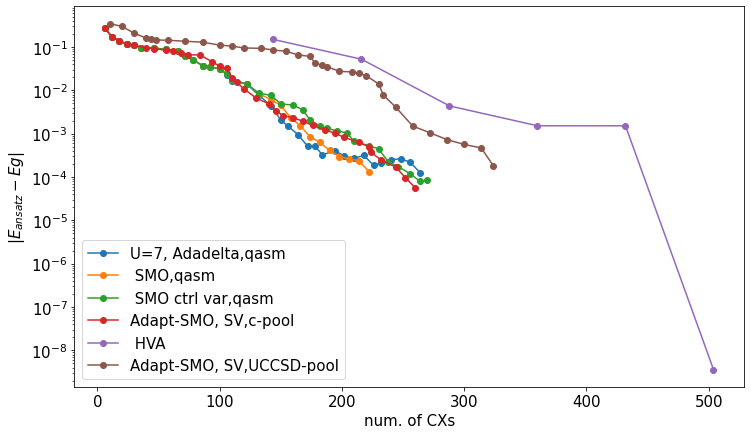

In [74]:
figure,ax=plt.subplots(1,figsize = (12,7))
ax.set_xlabel("num. of CXs",fontsize=15)
ax.set_ylabel(r'$|E_{ansatz}-Eg|$',fontsize=15)
ax.plot(numCXarr,numpy.abs(numpy.array(EnergyArrAdapt)-Eg),marker='o',linestyle='-',label='U='+str(U)+r', Adadelta,qasm')
ax.plot(numCXarr1,numpy.abs(numpy.array(EnergyArrAdapt1)-Eg),marker='o',linestyle='-',label=r' SMO,qasm ')
ax.plot(numCXarr2,numpy.abs(numpy.array(EnergyArrAdapt2)-Eg),marker='o',linestyle='-',label=r' SMO ctrl var,qasm')
ax.plot(CXarr,numpy.abs(numpy.array(Earr)-Eg),marker='o',linestyle='-',label=r'Adapt-SMO, SV,c-pool')
ax.plot(numCXarrHVA,numpy.abs(numpy.array(EnergyArrHVA)-Eg),marker='o',linestyle='-',label=r' HVA')
ax.plot(numCXarrUCCSD[:-2],numpy.abs(numpy.array(EnergyArrAdaptUCCSD)-Eg),marker='o',linestyle='-',label=r'Adapt-SMO, SV,UCCSD-pool')
ax.set_yscale('log')
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
    #ax[1].set_yscale('log')
    #ax[1].tick_params(labelsize=15)
    #ax[1].legend(fontsize=15)
plt.savefig("../"+str(U)+"/CX-U-%s.png"%str(U)) 


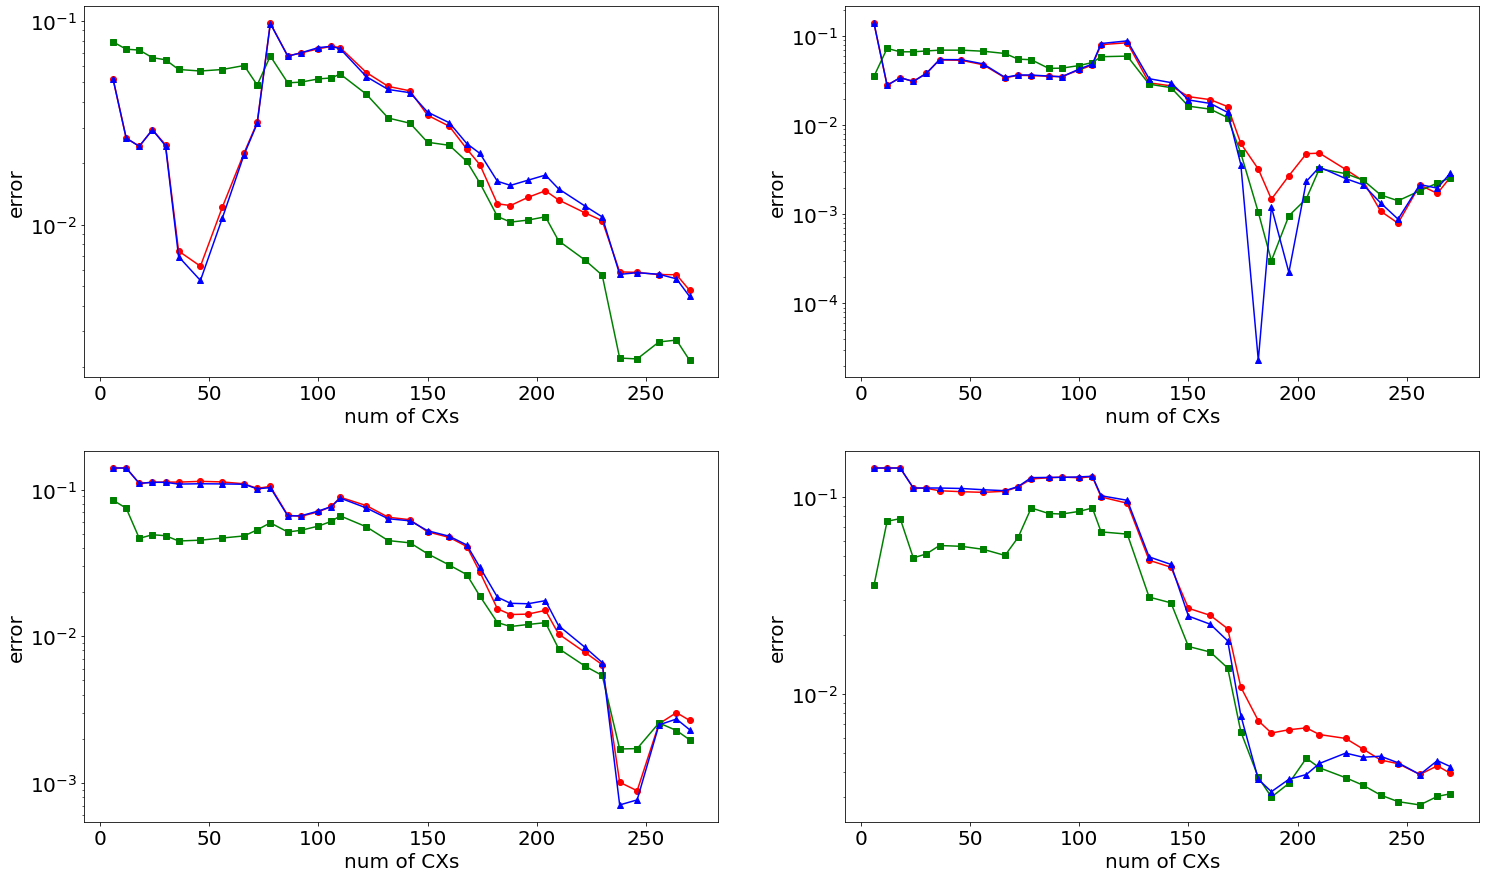

In [127]:
figure,ax=plt.subplots(2,2,figsize = (25,15))
error_arr=dm_error_arr_qasm2
ax[0][0].set_xlabel("num of CXs",fontsize=20)
ax[0][0].set_ylabel("error",fontsize=20)
ax[0][0].set_yscale('log')
ax[0][1].set_xlabel("num of CXs",fontsize=20)
ax[0][1].set_ylabel("error",fontsize=20)
ax[0][1].set_yscale('log')
ax[1][0].set_xlabel("num of CXs",fontsize=20)
ax[1][0].set_ylabel("error",fontsize=20)
ax[1][0].set_yscale('log')
ax[1][1].set_xlabel("num of CXs",fontsize=20)
ax[1][1].set_ylabel("error",fontsize=20)
ax[1][1].set_yscale('log')
ax[0][0].tick_params(labelsize=20)
ax[0][1].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)
ax[0][0].plot(CXarr_qasm2,error_arr[:,0],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{0\uparrow}\rangle$',color='r',marker='o')
ax[0][0].plot(CXarr_qasm2,error_arr[:,1],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{2\uparrow}\rangle$',color='g',marker='s')
ax[0][0].plot(CXarr_qasm2,error_arr[:,4],label=r'qasm-$\langle c^{\dagger}_{2\uparrow}c_{2\uparrow}\rangle$',color='b',marker='^')
ax[0][1].plot(CXarr_qasm2,error_arr[:,2],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{1\uparrow}\rangle$',color='r',marker='o')
ax[0][1].plot(CXarr_qasm2,error_arr[:,3],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{3\uparrow}\rangle$',color='g',marker='s')
ax[0][1].plot(CXarr_qasm2,error_arr[:,5],label=r'qasm-$\langle c^{\dagger}_{3\uparrow}c_{3\uparrow}\rangle$',color='b',marker='^')
ax[1][0].plot(CXarr_qasm2,error_arr[:,6],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{0\downarrow}\rangle$',color='r',marker='o')
ax[1][0].plot(CXarr_qasm2,error_arr[:,7],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{2\downarrow}\rangle$',color='g',marker='s')
ax[1][0].plot(CXarr_qasm2,error_arr[:,10],label=r'qasm-$\langle c^{\dagger}_{2\downarrow}c_{2\downarrow}\rangle$',color='b',marker='^')
ax[1][1].plot(CXarr_qasm2,error_arr[:,8],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{1\downarrow}\rangle$',color='r',marker='o')
ax[1][1].plot(CXarr_qasm2,error_arr[:,9],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{3\downarrow}\rangle$',color='g',marker='s')
ax[1][1].plot(CXarr_qasm2,error_arr[:,11],label=r'qasm-$\langle c^{\dagger}_{3\downarrow}c_{3\downarrow}\rangle$',color='b',marker='^')
plt.savefig("../"+str(U)+"/qasmRDM=SMOvariates-errorU=7.png")

In [122]:
error_arr[:,0].shape,len(CXarr_qasm)

((35,), 29)

NameError: name 'CXarrSV' is not defined

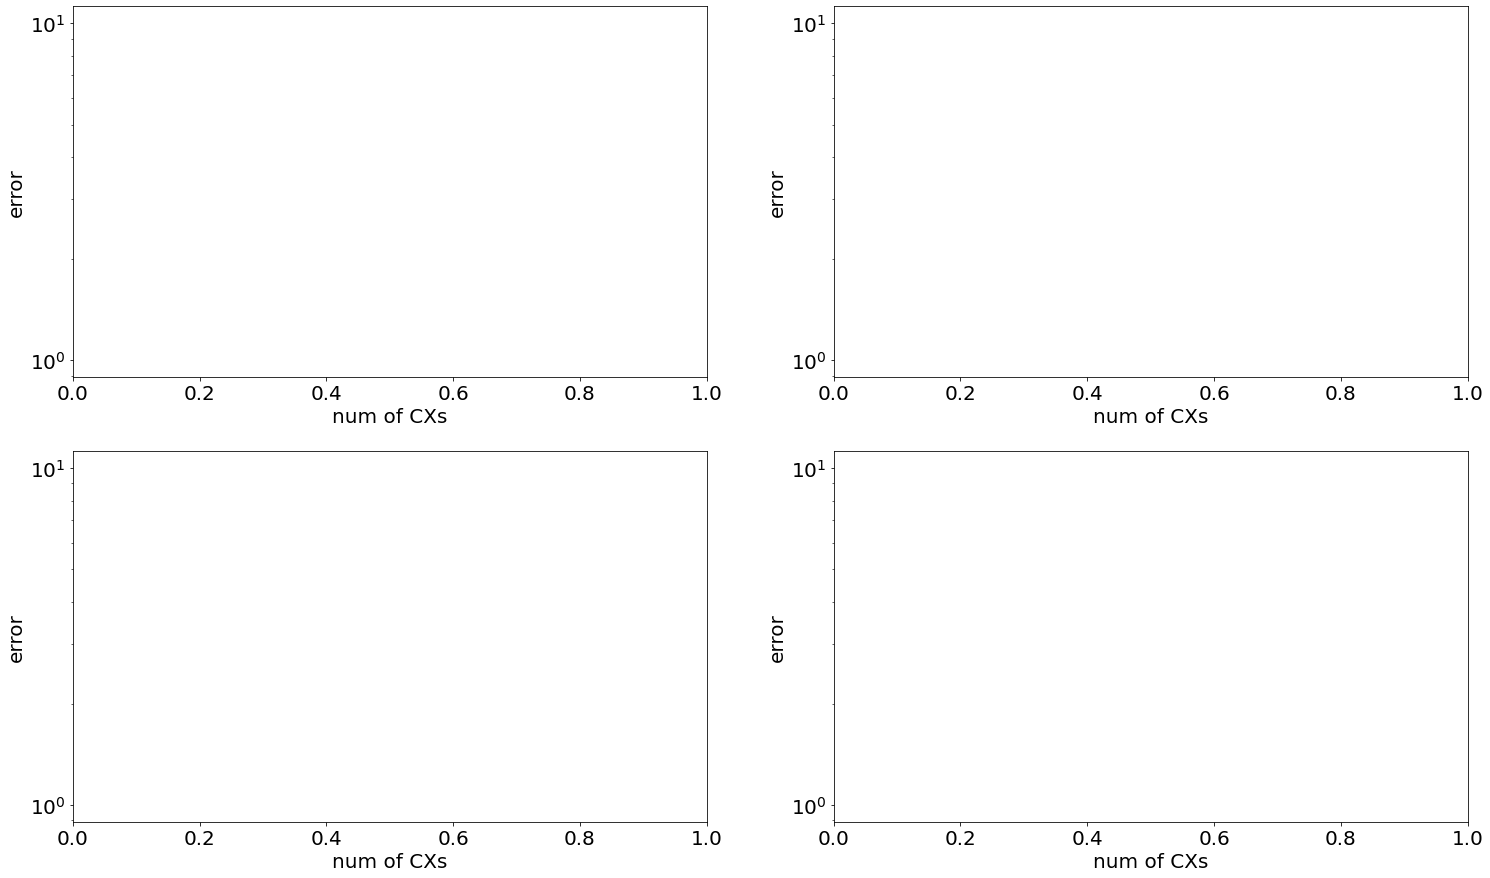

In [5]:
figure,ax=plt.subplots(2,2,figsize = (25,15))
error_arr=dm_error_arr_sv
ax[0][0].set_xlabel("num of CXs",fontsize=20)
ax[0][0].set_ylabel("error",fontsize=20)
ax[0][0].set_yscale('log')
ax[0][1].set_xlabel("num of CXs",fontsize=20)
ax[0][1].set_ylabel("error",fontsize=20)
ax[0][1].set_yscale('log')
ax[1][0].set_xlabel("num of CXs",fontsize=20)
ax[1][0].set_ylabel("error",fontsize=20)
ax[1][0].set_yscale('log')
ax[1][1].set_xlabel("num of CXs",fontsize=20)
ax[1][1].set_ylabel("error",fontsize=20)
ax[1][1].set_yscale('log')
ax[0][0].tick_params(labelsize=20)
ax[0][1].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)
ax[0][0].plot(CXarrSV,error_arr[:,0],label=r'SV-$\langle c^{\dagger}_{0\uparrow}c_{0\uparrow}\rangle$',color='red',marker='o',linestyle='--')
ax[0][0].plot(CXarrSV,error_arr[:,1],label=r'SV-$\langle c^{\dagger}_{0\uparrow}c_{2\uparrow}\rangle$',color='green',marker='s',linestyle='--')
ax[0][0].plot(CXarrSV,error_arr[:,4],label=r'SV-$\langle c^{\dagger}_{2\uparrow}c_{2\uparrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[0][1].plot(CXarrSV,error_arr[:,2],label=r'SV-$\langle c^{\dagger}_{1\uparrow}c_{1\uparrow}\rangle$',color='red',marker='o',linestyle='--')
ax[0][1].plot(CXarrSV,error_arr[:,3],label=r'SV-$\langle c^{\dagger}_{1\uparrow}c_{3\uparrow}\rangle$',color='green',marker='s',linestyle='--')
ax[0][1].plot(CXarrSV,error_arr[:,5],label=r'SV-$\langle c^{\dagger}_{3\uparrow}c_{3\uparrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[1][0].plot(CXarrSV,error_arr[:,6],label=r'SV-$\langle c^{\dagger}_{0\downarrow}c_{0\downarrow}\rangle$',color='red',marker='o',linestyle='--')
ax[1][0].plot(CXarrSV,error_arr[:,7],label=r'SV-$\langle c^{\dagger}_{0\downarrow}c_{2\downarrow}\rangle$',color='green',marker='s',linestyle='--')
ax[1][0].plot(CXarrSV,error_arr[:,10],label=r'SV-$\langle c^{\dagger}_{2\downarrow}c_{2\downarrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[1][1].plot(CXarrSV,error_arr[:,8],label=r'SV-$\langle c^{\dagger}_{1\downarrow}c_{1\downarrow}\rangle$',color='red',marker='o',linestyle='--')
ax[1][1].plot(CXarrSV,error_arr[:,9],label=r'SV-$\langle c^{\dagger}_{1\downarrow}c_{3\downarrow}\rangle$',color='green',marker='s',linestyle='--')
ax[1][1].plot(CXarrSV,error_arr[:,11],label=r'SV-$\langle c^{\dagger}_{3\downarrow}c_{3\downarrow}\rangle$',color='blue',marker='^',linestyle='--')
ax[0][0].legend(fontsize=15)
ax[0][1].legend(fontsize=15)
ax[1][0].legend(fontsize=15)
ax[1][1].legend(fontsize=15)

plt.savefig("../"+str(U)+"/svRDM-errorU=3.png")

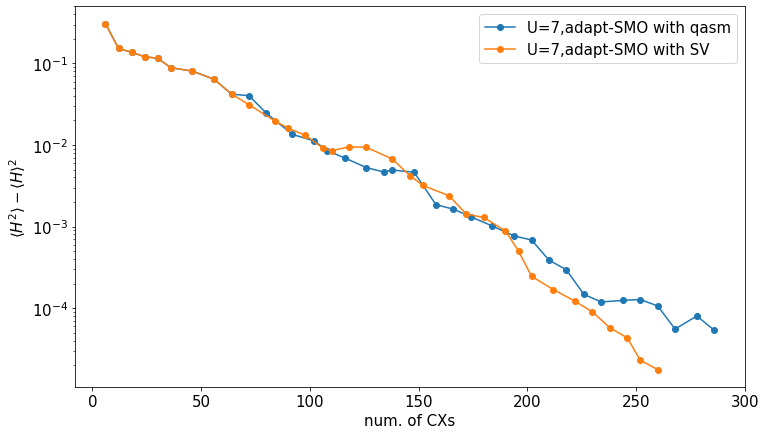

In [38]:
figure,ax=plt.subplots(1,figsize = (12,7))
ax.set_xlabel("num. of CXs",fontsize=15)
ax.set_ylabel(r'$\langle H^{2}\rangle-\langle H\rangle^{2}$',fontsize=15)
ax.plot(CXarr_qasm,EnergyFluc_qasm,marker='o',linestyle='-',label='U=7,adapt-SMO with qasm')
ax.plot(CXarrSV,EnergyFlucSV,marker='o',linestyle='-',label='U=7,adapt-SMO with SV')
ax.set_yscale('log')
ax.tick_params(labelsize=15)
#     ax[1].set_yscale('log')
#     ax[1].tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.savefig("../"+str(U)+"/FlucCXqasmASMO-U-%s.png"%str(U)) 
